[1/3] Memulai Proses Ekstraksi...
   📂 Mengekstrak 'Happy'...
      ✅ Berhasil!
   📂 Mengekstrak 'Relaxed'...
      ✅ Berhasil!
   📂 Mengekstrak 'Angry'...
      ✅ Berhasil!
   📂 Mengekstrak 'Sad'...
      ✅ Berhasil!

[2/3] Menganalisis Fitur Audio (Full Song)...
⚠️ PERHATIAN: Proses ini akan lama karena membaca durasi penuh semua lagu.
   🎵 Happy: Memproses 25 lagu...
      ...memproses lagu ke-5 dari 25
      ...memproses lagu ke-10 dari 25
      ...memproses lagu ke-15 dari 25
      ...memproses lagu ke-20 dari 25
      ...memproses lagu ke-25 dari 25
   🎵 Relaxed: Memproses 25 lagu...
      ...memproses lagu ke-5 dari 25
      ...memproses lagu ke-10 dari 25
      ...memproses lagu ke-15 dari 25
      ...memproses lagu ke-20 dari 25
      ...memproses lagu ke-25 dari 25
   🎵 Angry: Memproses 26 lagu...
      ❌ Error file angry.mp3: [Errno 21] Is a directory: '/content/dataset/Angry/angry.mp3'


/tmp/ipython-input-1019920252.py:73: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


      ...memproses lagu ke-5 dari 26
      ...memproses lagu ke-10 dari 26
      ...memproses lagu ke-15 dari 26
      ...memproses lagu ke-20 dari 26
      ...memproses lagu ke-25 dari 26
   🎵 Sad: Memproses 25 lagu...
      ...memproses lagu ke-5 dari 25
      ...memproses lagu ke-10 dari 25
      ...memproses lagu ke-15 dari 25
      ...memproses lagu ke-20 dari 25
      ...memproses lagu ke-25 dari 25

✅ DATA FINAL BERHASIL DIDAPATKAN!
         Tempo (BPM)  Energy (RMS)  Timbre (Centroid)
Mood                                                 
Angry     132.827112      0.216489        2365.820051
Happy     121.008295      0.207706        2488.278527
Relaxed   118.618232      0.212326        1871.420664
Sad       111.687400      0.216628        1671.153296
   File CSV tersimpan: final_audio_features_full.csv


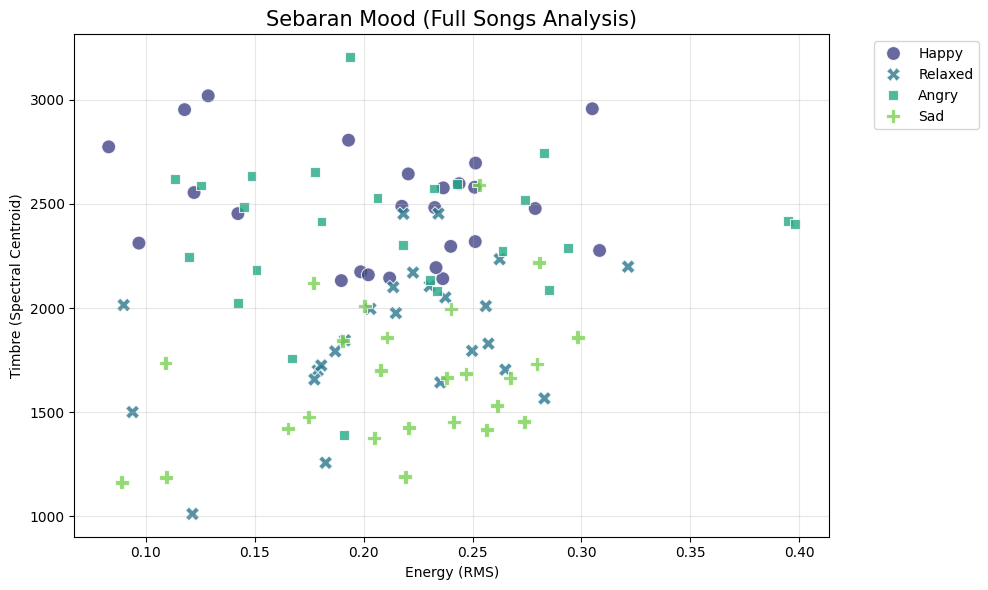

In [20]:
# ==============================================================================
# FINAL PROJECT AUDIO ANALYSIS: FULL DURATION & ALL SONGS
# ==============================================================================

import os
import zipfile
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. KONFIGURASI PATH
# ==============================================================================
print("[1/3] Memulai Proses Ekstraksi...")

# Mapping Label ke Path File Zip
zip_map = {
    'Happy':   '/content/happy.zip',
    'Relaxed': '/content/Relaxed Song.zip',
    'Angry':   '/content/angry.mp3.zip',
    'Sad':     '/content/Sad Mood Songs MP3.zip'
}

dataset_dir = '/content/dataset'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Proses Ekstraksi
for mood, zip_path in zip_map.items():
    target_folder = os.path.join(dataset_dir, mood)

    # Cek apakah file ada
    if os.path.exists(zip_path):
        print(f"   📂 Mengekstrak '{mood}'...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(target_folder)
            print(f"      ✅ Berhasil!")
        except zipfile.BadZipFile:
            print(f"      ❌ Gagal! File {zip_path} rusak.")
    else:
        print(f"      ⚠️ File tidak ditemukan: {zip_path}")


# 2. ANALISIS FITUR AUDIO (FULL VERSION)
# ==============================================================================
print("\n[2/3] Menganalisis Fitur Audio (Full Song)...")
print("⚠️ PERHATIAN: Proses ini akan lama karena membaca durasi penuh semua lagu.")

features = []

for mood in zip_map.keys():
    # Cari file audio
    search_path = os.path.join(dataset_dir, mood, '**')
    audio_files = glob.glob(search_path + '/*.mp3', recursive=True) + \
                  glob.glob(search_path + '/*.wav', recursive=True)

    total_files = len(audio_files)
    if total_files == 0: continue

    print(f"   🎵 {mood}: Memproses {total_files} lagu...")

    # Loop SEMUA lagu (tanpa batasan [:15])
    for i, filepath in enumerate(audio_files):
        try:
            # Tampilkan progress setiap 5 lagu biar tahu codingan jalan
            if (i+1) % 5 == 0:
                print(f"      ...memproses lagu ke-{i+1} dari {total_files}")

            # Load FULL DURATION (hapus parameter duration=30)
            y, sr = librosa.load(filepath)

            # A. TEMPO (BPM)
            tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
            if isinstance(tempo, np.ndarray): tempo = tempo[0]

            # B. ENERGY (RMS)
            rms = librosa.feature.rms(y=y)[0]
            avg_energy = np.mean(rms)

            # C. TIMBRE (Spectral Centroid)
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            avg_timbre = np.mean(cent)

            features.append({
                'Mood': mood,
                'Tempo (BPM)': tempo,
                'Energy (RMS)': avg_energy,
                'Timbre (Centroid)': avg_timbre
            })
        except Exception as e:
            print(f"      ❌ Error file {os.path.basename(filepath)}: {e}")

# 3. VISUALISASI HASIL
# ==============================================================================
if len(features) > 0:
    df = pd.DataFrame(features)

    print("\n✅ DATA FINAL BERHASIL DIDAPATKAN!")
    print(df.groupby('Mood').mean(numeric_only=True))

    # Simpan ke CSV
    df.to_csv('final_audio_features_full.csv', index=False)
    print("   File CSV tersimpan: final_audio_features_full.csv")

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df,
        x='Energy (RMS)',
        y='Timbre (Centroid)',
        hue='Mood',
        style='Mood',
        s=100,
        palette='viridis',
        alpha=0.8 # Transparansi biar kalau numpuk kelihatan
    )

    plt.title('Sebaran Mood (Full Songs Analysis)', fontsize=15)
    plt.xlabel('Energy (RMS)')
    plt.ylabel('Timbre (Spectral Centroid)')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

else:
    print("\n❌ Tidak ada data. Cek apakah file zip berhasil diekstrak.")

**Interpretasi Grafik (Scatter Plot)**

Ini adalah tujuan EDA. Tunjukkan grafik warna-warni yang dihasilkan kodemu tadi.

Jika Titik-Titik Menggerombol (Cluster):

Contoh: Titik-titik Angry (misal warna Ungu) ngumpul di pojok kanan atas (Energi Tinggi, Timbre Tinggi).

Contoh: Titik-titik Sad (misal warna Hijau) ngumpul di pojok kiri bawah (Energi Rendah, Timbre Rendah).

Kesimpulan:

"Lihat grafiknya, titik-titik Mood Angry terpisah jauh dari Mood Sad. Ini artinya fitur yang kita pilih (Energi & Timbre) SUDAH BAGUS."

"Karena datanya terpisah secara visual, nanti algoritma Machine Learning (seperti XGBoost atau Random Forest) akan mudah menarik garis batas untuk membedakan lagu."

**Dari EDA ke Machine Learning (Final)**

Bagaimana angka ini jadi ML?

File CSV: Hasil akhirnya adalah file CSV (final_audio_features.csv). File ini isinya bukan lagi .mp3, tapi tabel:
| Filename | Energy | Timbre | Tempo | Label (Target) |
| :--- | :--- | :--- | :--- | :--- |
| angry1.mp3 | 0.85 | 4000 | 140 | Angry |
| sad1.mp3 | 0.20 | 1200 | 70 | Sad |

Training: Kamu akan "menyuapi" tabel ini ke model AI.

Belajar Pola: AI akan belajar aturan: "Oh, kalau Energy > 0.8 dan Timbre > 3500, maka ini pasti ANGRY."

Prediksi: Saat ada lagu baru masuk, AI mengekstrak angkanya, mencocokkan dengan aturan tadi, dan menebak mood-nya.

# PENJELASAN (What are these numbers?)

**A. Energy (RMS - Root Mean Square) -> Mewakili "Arousal"**

Definisi: Mengukur seberapa "keras" atau "intens" volume suara rata-rata dalam lagu.

Cara Kerja Librosa: Dia menghitung amplitudo (tinggi rendahnya gelombang) setiap milidetik, lalu dirata-rata.

Logika Manusia:

Lagu Angry (Metal/Rock) pasti teriak-teriak & full instrument = Energi Tinggi.

Lagu Sad (Piano/Akustik) biasanya pelan & sunyi = Energi Rendah.

Lagu Relaxed (Lofi) = Energi Rendah/Sedang.

Hubungan ke ML: Fitur ini memisahkan sumbu X (Kiri vs Kanan).

**B. Timbre (Spectral Centroid) -> Mewakili Warna Suara (Valence Proxy)**

Definisi: Titik pusat massa dari frekuensi suara. Sering disebut kecerahan (brightness) suara.

Cara Kerja Librosa: Menggunakan Fourier Transform untuk memecah suara jadi frekuensi.

Logika Manusia:

Suara Cerah/Tajam : Distorsi gitar, cymbal drum, teriak, suara melengking = Centroid Tinggi (Biasanya Angry/Happy).

Suara Gelap/Berat: Bass, cello, suara mendem, piano rendah = Centroid Rendah (Biasanya Sad/Relaxed).

Hubungan ke ML: Fitur ini membantu membedakan emosi yang energinya sama tapi rasanya beda (misal: Happy vs Angry).

**C. Tempo (BPM - Beats Per Minute)**
Definisi: Kecepatan ketukan lagu.  

Cara Kerja Librosa: Mendeteksi onset (serangan awal bunyi drum/bass) yang berulang secara periodik.

Logika Manusia:

Happy/Angry: Biasanya nge-beat cepat (>120 BPM).

Sad/Relaxed: Biasanya lambat (<90 BPM).